In [1]:
%matplotlib inline
import numpy as np
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, widgets, Dropdown
from IPython.display import display
from glob import glob
from sharppy.sharptab.profile import create_profile
from pycaps.derive import dewp_fm_qv
from pycaps.derive.derive_functions import calc_mesh
from datetime import datetime
from matplotlib.colors import ListedColormap

/Users/djgagne/miniconda2/lib/python2.7/site-packages/SHARPpy-1.3.0-py2.7.egg/sharppy/sharptab/winds.py:14: UserWarning: Future versions of the routines in the winds module may include options to use height values instead of pressure to specify layers (i.e. SRH, wind shear, etc.)
  warnings.warn("Future versions of the routines in the winds module may include options to use height values instead of pressure to specify layers (i.e. SRH, wind shear, etc.)")


In [20]:
filename = "/Users/djgagne/wrfobjs_spring2016/wrf-core03_arw/20160428/wrfobjects_d01_2016-04-29_020000.nc"


In [21]:
wrf_data = dict()
obj_name = 'wrf_object_0000'
d = Dataset(filename)
print d.groups.keys()
for v in d.groups[obj_name].variables.keys():
    wrf_data[v] = d.groups[obj_name].variables[v][:]
    if v == "XTIME":
        wrf_data[v] = num2date(d.groups[obj_name].variables[v][:],d.groups[obj_name].variables[v].units)
d.close()

[u'wrf_object_0000', u'wrf_object_0001', u'wrf_object_0002', u'wrf_object_0003', u'wrf_object_0004']


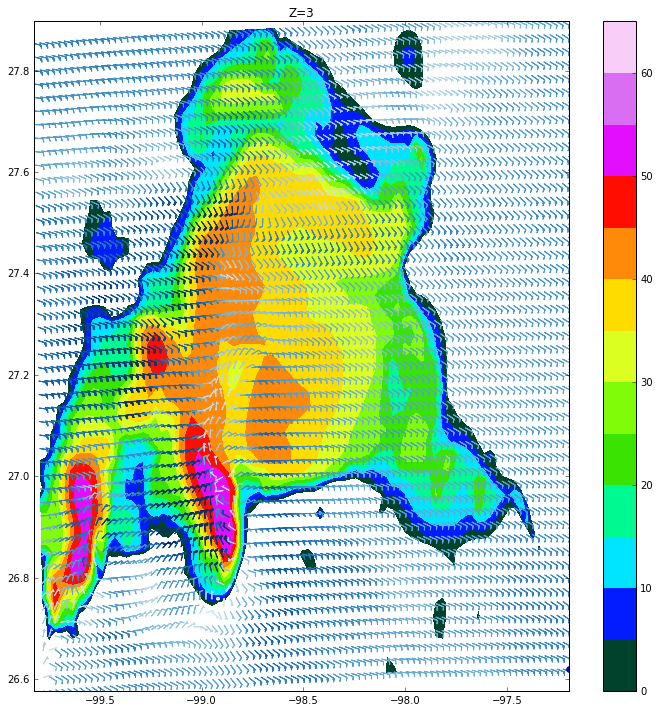

In [157]:
stride = 1
def plot_refl_winds_level(z):
    fig, ax = plt.subplots(figsize=(12, 12))
    plt.contourf(wrf_data["XLONG"][0], wrf_data["XLAT"][0], wrf_data["REFL_10CM"][0,z], 
                 np.arange(0, 70, 5), cmap='gist_ncar')
    plt.barbs(wrf_data["XLONG"][0, ::stride, ::stride], wrf_data["XLAT"][0, ::stride, ::stride], 
              wrf_data["U"][0, z, ::stride, ::stride], wrf_data["V"][0, z, ::stride, ::stride],
              np.sqrt(wrf_data["U"][0, z, ::stride, ::stride] ** 2 + wrf_data["V"][0, z, ::stride, ::stride]**2),
              length=4, cmap="Blues",clim=(0, 20))
    plt.plot(wrf_data["XLONG"][0,0,-1], wrf_data["XLAT"][0,0,-1],'bo')

    plt.title("Z={0:d}".format(z))
    plt.xlim(wrf_data["XLONG"][0].min(), wrf_data["XLONG"][0].max())
    plt.ylim(wrf_data["XLAT"][0].min(), wrf_data["XLAT"][0].max())
    plt.colorbar()
z_slider = IntSlider(min=0, max=wrf_data["REFL_10CM"].shape[1], step=1)
w = widgets.interactive(plot_refl_winds_level, z=z_slider)
display(w)

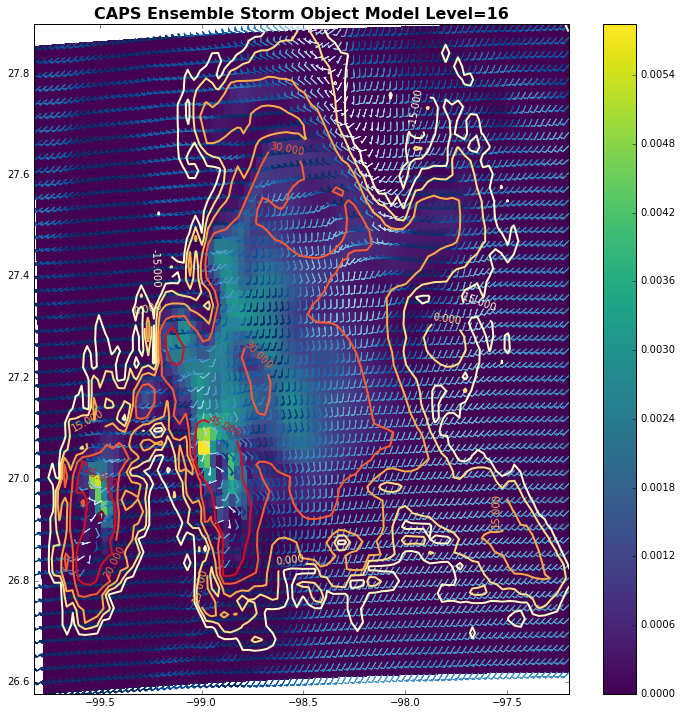

In [22]:
stride = 1
z = 0

def plot_refl_winds_level(z, s, f):
    fig, ax = plt.subplots(figsize=(12, 12))
    if len(wrf_data[f].shape) == 4:
        cont = ax.pcolormesh(wrf_data["XLONG"][0], wrf_data["XLAT"][0], 
                             wrf_data[f][0,z], 
                     vmin=wrf_data[f][0,z].min(), vmax=wrf_data[f][0,z].max(), cmap='viridis')
    else:
        cont = ax.pcolormesh(wrf_data["XLONG"][0], wrf_data["XLAT"][0], 
                             wrf_data[f][0], 
                     vmin=wrf_data[f][0,z].min(), vmax=wrf_data[f][0,z].max(), cmap='viridis')
    if len(wrf_data[s].shape) == 4 and wrf_data[s][0,z].max() != wrf_data[s][0,z].min():
        cont2 = plt.contour(wrf_data["XLONG"][0], wrf_data["XLAT"][0], wrf_data[s][0, z], cmap="YlOrRd", linewidths=2)
        plt.clabel(cont2, fmt="%1.3f")

    elif len(wrf_data[s].shape) == 3 and wrf_data[s][0,z].max() != wrf_data[s][0,z].min():
        cont2 = plt.contour(wrf_data["XLONG"][0], wrf_data["XLAT"][0], wrf_data[s][0], cmap="YlOrRd", linewidths=2)
        plt.clabel(cont2, fmt="%1.3f")
    barb = ax.barbs(wrf_data["XLONG"][0, ::stride, ::stride], wrf_data["XLAT"][0, ::stride, ::stride], 
              wrf_data["U"][0, z, ::stride, ::stride], wrf_data["V"][0, z, ::stride, ::stride],
              np.sqrt(wrf_data["U"][0, z, ::stride, ::stride] ** 2 + wrf_data["V"][0, z, ::stride, ::stride]**2),
              length=4, cmap="Blues",clim=(0, 20)) 
    plt.xlim(wrf_data["XLONG"][0].min(), wrf_data["XLONG"][0].max())
    plt.ylim(wrf_data["XLAT"][0].min(), wrf_data["XLAT"][0].max())
    plt.title("CAPS Ensemble Storm Object Model Level={0:d}".format(z), fontweight="bold", fontsize=16)
    plt.colorbar(cont)
z_slider = IntSlider(min=0, max=wrf_data["REFL_10CM"].shape[1], step=1, description="Model Z Level")
sel = Dropdown(options=wrf_data.keys(), value="REFL_10CM", description="Contour Variable")
fsel = Dropdown(options=wrf_data.keys(), value="W", description="Fill Variable")

w = widgets.interactive(plot_refl_winds_level, z=z_slider, s=sel, f=fsel)
display(w)

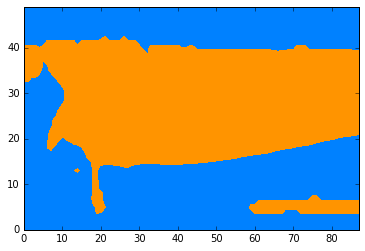

In [85]:
plt.contourf(wrf_data["CLDFRA"][0][:,20],[0,0.5,1])

In [43]:
wrf_dir = "/Users/djgagne/wrfobjs_spring2016/wrf-core03_arw/20160428/"
all_wrf_files = sorted(glob(wrf_dir + "*.nc"))
wrf_obj_boxes = []
for wrf_filename in all_wrf_files:
    wrf_dset = Dataset(wrf_filename)
    for wo in wrf_dset.groups.keys():
        wrf_obj_boxes.append([getattr(wrf_dset.groups[wo], x) for x in wrf_dset.groups[wo].ncattrs()])
    wrf_dset.close()

(0, 1153)

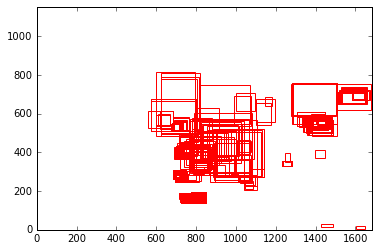

In [51]:
fig, ax = plt.subplots()
import matplotlib.patches as patches
for b in wrf_obj_boxes:
    ax.add_patch(patches.Rectangle((b[2], b[0]),b[3]-b[2],b[1]-b[0], fill=False, color="red"))
plt.xlim(0, 1681)
plt.ylim(0, 1153)

In [59]:
e = Dataset(wrf_filename)
print e
e.close()

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    NUM_LAND_CAT: 24
    ISWATER: 16
    W_DAMPING: 1
    AER_ANGEXP_OPT: 1
    RA_SW_PHYSICS: 4
    TRACER_PBLMIX: 1
    PARENT_GRID_RATIO: 1
    GRIDTYPE: C
    DIFF_6TH_FACTOR: 0.12
    SKEBS_ON: 0
    AER_AOD550_VAL: 0.12
    SF_OCEAN_PHYSICS: 0
    MAP_PROJ: 1
    SGFDDA_INTERVAL_M: 0
    AER_OPT: 0
    GRID_FDDA: 0
    BOTTOM-TOP_PATCH_END_UNSTAG: 50
    GRID_ID: 1
    DAMP_OPT: 0
    HYPSOMETRIC_OPT: 2
    WEST-EAST_PATCH_START_STAG: 1
    USE_THETA_M: 0
    MMINLU: USGS
    KM_OPT: 4
    JULYR: 2016
    CEN_LON: -97.0
    MAP_PROJ_CHAR: Lambert Conformal
    ICLOUD: 1
    GRID_SFDDA: 0
    AER_SSA_VAL: 1.4013e-45
    J_PARENT_START: 1
    AER_ASY_OPT: 1
    AER_SSA_OPT: 1
    ISOILWATER: 14
    AER_AOD550_OPT: 1
    GRAV_SETTLING: 0
    ICLOUD_CU: 0
    GFDDA_INTERVAL_M: 0
    AER_ANGEXP_VAL: 1.3
    JULDAY: 119
    SOUTH-NORTH_PATCH_START_UNSTAG: 1
    ISURBAN: 1
    STAND_LON: -97.0
    MOAD_

In [16]:
def create_wrf_sounding(wrf_data, i=0, j=-1):
    prof = dict()
    prof["tmpc"] = wrf_data["TEMP"][0,:, i, j] - 273.15
    prof["dwpc"] = dewp_fm_qv(qv=wrf_data["QVAPOR"][0,:, i, j], p=wrf_data["PRES"][0,:,i,j] * 100) - 273.15
    prof["pres"] = wrf_data["PRES"][0,:,i, j]
    prof["hght"] = wrf_data["GPH"][0,:,i,j]
    prof["u"] = wrf_data["U"][0, :, i, j]
    prof["v"] = wrf_data["V"][0, :, i, j]
    prof["profile"] = "convective"
    prof["latitude"] = wrf_data["XLAT"][0, i, j]
    prof["longitude"] = wrf_data["XLONG"][0, i, j]
    prof["date"] = wrf_data["XTIME"][0]
    prof["location"] = "WRF"
    s_prof = create_profile(**prof)
    return s_prof

s_prof = create_wrf_sounding(wrf_data)

/Users/djgagne/miniconda2/lib/python2.7/site-packages/numpy/ma/core.py:4139: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


In [46]:
s_prof.toFile("./wrf_sounding.txt")

In [30]:
watch_type_grid = []
for i in range(wrf_data["TEMP"].shape[2])[::5]:
    for j in range(wrf_data["TEMP"].shape[3])[::5]:
        s_prof_g = create_wrf_sounding(wrf_data, i, j)
        watch_type_grid.append(s_prof_g.watch_type)
        print i,j, watch_type_grid[-1]


0 0 MRGL TOR
0 5 TOR
0 10 TOR
0 15 TOR
0 20 TOR
0 25 MRGL TOR
0 30 MRGL TOR
0 35 TOR
0 40 MRGL TOR
0 45 NONE
0 50 NONE
0 55 NONE
0 60 NONE
0 65 NONE
0 70 NONE
0 75 NONE
0 80 NONE
0 85 NONE
5 0 SVR
5 5 TOR
5 10 TOR
5 15 TOR
5 20 SVR
5 25 MRGL TOR
5 30 TOR
5 35 TOR
5 40 MRGL TOR
5 45 NONE
5 50 NONE
5 55 NONE
5 60 NONE
5 65 NONE
5 70 NONE
5 75 NONE
5 80 NONE
5 85 NONE
10 0 SVR
10 5 NONE
10 10 MRGL SVR
10 15 NONE
10 20 SVR
10 25 NONE
10 30 MRGL SVR
10 35 TOR
10 40 MRGL TOR
10 45 NONE
10 50 NONE
10 55 NONE
10 60 NONE
10 65 NONE
10 70 NONE
10 75 NONE
10 80 NONE
10 85 NONE
15 0 NONE
15 5 NONE
15 10 MRGL SVR
15 15 MRGL SVR
15 20 MRGL SVR
15 25 NONE
15 30 NONE
15 35 SVR
15 40 MRGL TOR
15 45 NONE
15 50 NONE
15 55 NONE
15 60 NONE
15 65 NONE
15 70 NONE
15 75 NONE
15 80 NONE
15 85 NONE
20 0 NONE
20 5 SVR
20 10 SVR
20 15 NONE
20 20 MRGL SVR
20 25 MRGL SVR
20 30 NONE
20 35 MRGL SVR
20 40 MRGL SVR
20 45 MRGL SVR
20 50 NONE
20 55 NONE
20 60 NONE
20 65 NONE
20 70 NONE
20 75 NONE
20 80 NONE
20 85 NONE
25

In [8]:
pot_temp = wrf_data["TEMP"] * (1000.0 / wrf_data["PRES"]) ** 0.286
mesh_out = calc_mesh(dBZ=wrf_data["REFL_10CM"][0],pt=pot_temp[0], p=wrf_data["PRES"][0] * 100, zp=wrf_data["GPH"][0])

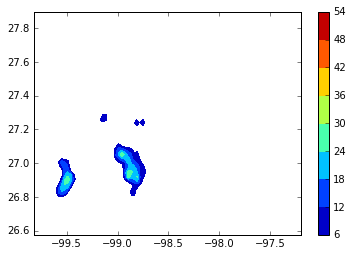

In [13]:
plt.contourf(wrf_data["XLONG"][0], wrf_data["XLAT"][0], mesh_out, np.arange(6, 56, 6))
plt.colorbar()

(10, 18)


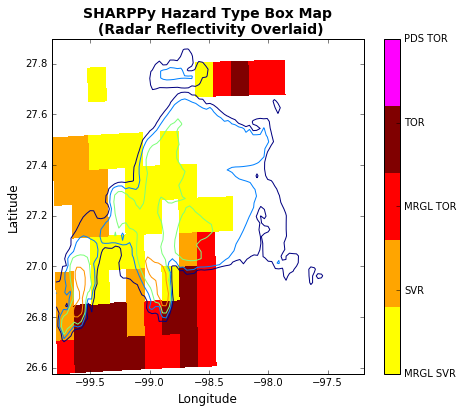

In [62]:
wtg = np.array(watch_type_grid).reshape(10,18)
print wtg.shape
wtg_num = np.zeros(wtg.shape)
wtg_num[wtg == "TOR"] = 4
wtg_num[wtg == "MRGL TOR"] = 3
wtg_num[wtg == "SVR"] = 2
wtg_num[wtg == "MRGL SVR"] = 1
plt.figure(figsize=(7, 6))
plt.contour(wrf_data["XLONG"][0], wrf_data["XLAT"][0], wrf_data["REFL_10CM"][0,0], np.arange(20, 70, 10))
cm = ListedColormap(["yellow", "orange", "red", "maroon", "magenta"])
pcm = plt.pcolormesh(wrf_data["XLONG"][0, ::5, ::5], wrf_data["XLAT"][0,::5,::5], 
                     np.ma.array(wtg_num, mask=wtg_num<1), vmin=1, vmax=5, cmap=cm)
cbar = plt.colorbar(pcm)
cbar.set_ticks(np.arange(1, 6))
cbar.set_ticklabels(["MRGL SVR", "SVR", "MRGL TOR", "TOR", "PDS TOR"])
plt.title("SHARPPy Hazard Type Box Map\n (Radar Reflectivity Overlaid)", fontsize=14, fontweight="bold")
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.savefig("sharppy_hazard_box_map.png", dpi=250, bbox_inches="tight")

In [160]:
de = Dataset(filename)
grp = de.groups["wrf_object_0000"]
out = Dataset("wrf_out.nc", "w")
for attr in de.ncattrs():
    setattr(out, attr, getattr(de, attr))
for dim in grp.dimensions.keys():
    out.createDimension(dim, len(grp.dimensions[dim]))
#out.createDimension("x", len(grp.dimensions["west_east"]))
#out.createDimension("y", len(grp.dimensions["south_north"]))
#out.createDimension("z", len(grp.dimensions["bottom_top"]))
#out.createDimension("time", len(grp.dimensions["time"]))
for var in grp.variables.keys():
    if len(grp.variables[var].dimensions) == 3:
        v = out.createVariable(var, "f4", ("time", "south_north", "west_east"), zlib=False)
        for vattr in grp.variables[var].ncattrs():
            setattr(v, vattr, getattr(grp.variables[var], vattr))
        v.coordinates = "latitude longitude time"
    elif len(grp.variables[var].dimensions) == 4:
        v = out.createVariable(var, "f4", ("time", "bottom_top", "south_north", "west_east"))
        for vattr in grp.variables[var].ncattrs():
            setattr(v, vattr, getattr(grp.variables[var], vattr))
        v.coordinates = "latitude longitude time pressure"

    else:
        v = out.createVariable(var, "f4", ("time",))
        for vattr in grp.variables[var].ncattrs():
            setattr(v, vattr, getattr(grp.variables[var], vattr))
    v[:] = grp.variables[var][:]
    
t = out.createVariable("time", "i4", ("time", ))
t[:] = out.variables["XTIME"][:]
t.units = out.variables["XTIME"].units
t.long_name = "time"
we = out.createVariable("x", "f4", ("west_east",))
we[:] = np.arange(0, out.variables["XLONG"].shape[2] * 3000, 3000)
we.units = "m"
we.long_name = "x"
we.standard_name = "x"
we.axis="X"
sn = out.createVariable("y", "f4", ("south_north",))
sn[:] = np.arange(0, out.variables["XLONG"].shape[1] * 3000, 3000)
sn.long_name = "y"
sn.standard_name = "y"
sn.units = "m"
sn.axis="Y"
h = out.createVariable("height", "f4", ("bottom_top", "south_north", "west_east"))
h[:] = out.variables["GPH"][0]
h.long_name = 'height'
h.standard_name = "height"
h.units = "m"
h.positive = "up"
h.axis="Z"
out.Conventions="CF-1.6"
out.close()
de.close()

In [134]:
e = Dataset("wrfobjects_d01_2016-04-28_220000.nc", "a")

In [123]:
e.groups["wrf_object_0000"].variables["XLAT"].axis="Y"
e.groups["wrf_object_0000"].variables["XLONG"].axis="X"
e.groups["wrf_object_0000"].variables["GPH"].axis="Z"
e.groups["wrf_object_0000"].variables["GPH"].positive = "up"
e.close()

In [129]:
wrf_data["GPH"][0, 10].min()

1671.0487

In [149]:
znu = """0.999, 0.9960001, 0.9905, 0.981, 0.967, 0.949, 0.9275, 0.904, 0.8785, 0.85, 
    0.8185, 0.784, 0.7465, 0.706, 0.6625, 0.616, 0.567, 0.5195, 0.47675, 
    0.4385, 0.4041, 0.37295, 0.34495, 0.31975, 0.29705, 0.27665, 0.2583, 
    0.24125, 0.22585, 0.21175, 0.19765, 0.18355, 0.16945, 0.15535, 0.14125, 
    0.12715, 0.11305, 0.09895, 0.08485, 0.07175, 0.06125, 0.0527, 0.04475, 
    0.0373, 0.0304, 0.024, 0.018, 0.0124, 0.0072, 0.00235"""
znu = np.array(znu.replace("\n","").replace(" ","").split(","), dtype=float)

In [162]:
def ungroup_netcdf_file(filename, out_path):
    data_obj = Dataset(filename)
    for grp_name, grp_obj in data_obj.groups.items():
        out_filename = filename.split("/")[-1].replace(".nc", "_" + grp_name.split("_")[-1] + ".nc")
        out_obj = Dataset(out_path + out_filename, "w")
        for attr in grp_obj.ncattrs():
            setattr(out_obj, attr, getattr(grp_obj, attr))
        for attr in data_obj.ncattrs():
            setattr(out_obj, attr, getattr(data_obj, attr))
        for dim in grp_obj.dimensions.keys():
            out_obj.createDimension(dim, len(grp_obj.dimensions[dim]))
        for var in grp_obj.variables.keys():
            out_var = out_obj.createVariable(var, "f4", grp_obj.variables[var].dimensions, zlib=True)
            out_var[:] = grp_obj.variables[var][:]
            for attr in grp_obj.variables[var].ncattrs():
                setattr(out_obj.variables[var], attr, getattr(grp_obj.variables[var], attr))
        x_var = out_obj.createVariable("x", "f4", ("west_east",))
        x_var[:] = np.arange(grp_obj.WEST_EAST_BOX_START_C * 3000, grp_obj.WEST_EAST_BOX_END_C * 3000, 3000)
        x_var.standard_name = "x"
        x_var.long_name = "x"
        x_var.units = "m"
        x_var.axis= "X"
        y_var = out_obj.createVariable("y", "f4", ("south_north",))
        y_var[:] = np.arange(grp_obj.SOUTH_NORTH_BOX_START_C * 3000, grp_obj.SOUTH_NORTH_BOX_END_C * 3000, 3000)
        y_var.standard_name = "y"
        y_var.long_name = "y"
        y_var.units = "m"
        y_var.axis= "Y"
        z_var = out_obj.createVariable("z", "f4", ("bottom_top", "south_north", "west_east"))
        z_var[:] = out_obj.variables["GPH"][:]
        z_var.long_name = "z"
        z_var.standard_name = "z"
        z_var.units = "m"
        z_var.axis = "Z"
        z_var.positive = "up"
        t_var = out_obj.createVariable("time", "i4", ("time",))
        t_var[:] = grp_obj.variables["XTIME"][:]
        t_var.units = grp_obj.variables["XTIME"].units
        t_var.long_name = "time"
        out_obj.close()
    data_obj.close()

nc_files = sorted(glob("/Users/djgagne/wrfobjs_spring2016/wrf-core03_arw/20160428/*.nc"))
out_path = "/Users/djgagne/wrfobjs_spring2016_ungrouped/wrf-core03_arw/20160428/"
for nc_file in nc_files:
    print nc_file
    ungroup_netcdf_file(nc_file, out_path)
        

/Users/djgagne/wrfobjs_spring2016/wrf-core03_arw/20160428/wrfobjects_d01_2016-04-28_010000.nc
/Users/djgagne/wrfobjs_spring2016/wrf-core03_arw/20160428/wrfobjects_d01_2016-04-28_020000.nc
/Users/djgagne/wrfobjs_spring2016/wrf-core03_arw/20160428/wrfobjects_d01_2016-04-28_030000.nc
/Users/djgagne/wrfobjs_spring2016/wrf-core03_arw/20160428/wrfobjects_d01_2016-04-28_040000.nc
/Users/djgagne/wrfobjs_spring2016/wrf-core03_arw/20160428/wrfobjects_d01_2016-04-28_050000.nc
/Users/djgagne/wrfobjs_spring2016/wrf-core03_arw/20160428/wrfobjects_d01_2016-04-28_080000.nc
/Users/djgagne/wrfobjs_spring2016/wrf-core03_arw/20160428/wrfobjects_d01_2016-04-28_100000.nc
/Users/djgagne/wrfobjs_spring2016/wrf-core03_arw/20160428/wrfobjects_d01_2016-04-28_110000.nc
/Users/djgagne/wrfobjs_spring2016/wrf-core03_arw/20160428/wrfobjects_d01_2016-04-28_130000.nc
/Users/djgagne/wrfobjs_spring2016/wrf-core03_arw/20160428/wrfobjects_d01_2016-04-28_160000.nc
/Users/djgagne/wrfobjs_spring2016/wrf-core03_arw/20160428/wr

In [18]:
nc_files = sorted(glob("/Users/djgagne/wrfobjs_spring2016/wrf-core01_arw/20160509/*.nc"))
for nc_file in nc_files[1:10]:
    d = Dataset(nc_file, "a")
    d.variables["time"][:] = d.variables["XTIME"][:] * 60
    d.variables["time"].units = d.variables["XTIME"].units.replace("minutes", "seconds")
    #z = d.variables["bottom_top"]
    z = d.createVariable("bottom_top", "f4", ("bottom_top",))
    z[:] = d.variables["z"][:].mean(axis=2).mean(axis=1)
    z.units = "m"
    z.long_name = "bottom_top"
    z.standard_name = "bottom_top"
    sn = d.createVariable("south_north", "f4", ("south_north",))
    #sn = d.variables["south_north"]
    sn[:] = d.variables["y"][:]
    sn.units = "m"
    sn.long_name = "south_north"
    sn.standard_name = "west_east"
    we = d.createVariable("west_east", "f4", ("west_east", ))
    #we = d.variables["west_east"]
    we[:] = d.variables["x"][:]
    we.long_name = "west_east"
    we.standard_name = "west_east"
    we.units = "m"
    d.close()

In [17]:
print nc_files[0:10]

['/Users/djgagne/wrfobjs_spring2016/wrf-core01_arw/20160509/wrfobjects_d01_2016-05-09_010000_0000.nc', '/Users/djgagne/wrfobjs_spring2016/wrf-core01_arw/20160509/wrfobjects_d01_2016-05-09_010000_0001.nc', '/Users/djgagne/wrfobjs_spring2016/wrf-core01_arw/20160509/wrfobjects_d01_2016-05-09_010000_0002.nc', '/Users/djgagne/wrfobjs_spring2016/wrf-core01_arw/20160509/wrfobjects_d01_2016-05-09_010000_0003.nc', '/Users/djgagne/wrfobjs_spring2016/wrf-core01_arw/20160509/wrfobjects_d01_2016-05-09_010000_0004.nc', '/Users/djgagne/wrfobjs_spring2016/wrf-core01_arw/20160509/wrfobjects_d01_2016-05-09_010000_0005.nc', '/Users/djgagne/wrfobjs_spring2016/wrf-core01_arw/20160509/wrfobjects_d01_2016-05-09_010000_0006.nc', '/Users/djgagne/wrfobjs_spring2016/wrf-core01_arw/20160509/wrfobjects_d01_2016-05-09_010000_0007.nc', '/Users/djgagne/wrfobjs_spring2016/wrf-core01_arw/20160509/wrfobjects_d01_2016-05-09_010000_0008.nc', '/Users/djgagne/wrfobjs_spring2016/wrf-core01_arw/20160509/wrfobjects_d01_2016-05